In [4]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
from pathlib import Path

dir_ = Path(globals()["_dh"][0])  # __file__ does not exist in ipynb

In [49]:
def read_wpd_csv(
    filepath: Path | str, x_coord: str, ds_coord: str | None = None
) -> xr.DataArray:
    filepath = Path(filepath)

    header = np.loadtxt(filepath, dtype=str, max_rows=2, delimiter=",")
    header_values = header[0][::2]
    try:
        np.array(header_values, dtype=float)
    except ValueError:
        np.array(header_values)

    values = np.loadtxt(filepath, dtype=float, skiprows=2, delimiter=",")

    coords = dict()
    dims = [x_coord]
    if ds_coord is not None:
        dims.append(ds_coord)
        coords[ds_coord] = header_values

    for col in range(int(values.shape[1] / 2)):
        x = values[:, col * 2]
        if col == 0:
            coords[x_coord] = x
        else:
            if np.any(x != coords[x_coord]):
                raise ValueError(f"All webplotdigitizer datasets must share x values")

    da = xr.DataArray(
        values[:, 1::2],
        dims=dims,
        coords=coords,
        attrs=dict(filename=filepath.name),
    )
    return da

In [78]:
# LED properties
LEDS = {
    "APHHS1005F3C-70MAV": dict(
        emissivity=8e-3,  # W/sr
        emissivity_current=70e-3,  # A
    )
}

# Photodiode properties
PHOTODIODES = {
    "PD15-22B/TR8": dict(
        dark_current=5e-9,  # A
        light_current=read_wpd_csv(
            dir_ / "data/PD15-22B/reverse_light_current.csv",
            "irradiance",
            "vr",
        ).isel(vr=0),
    ),
    "TEMD5110X01": dict(
        dark_current=3e-9,  # A
        light_current=read_wpd_csv(
            dir_ / "data/TEMD5110X01/reverse_light_current.csv",
            "irradiance",
            "vr",
        ).isel(vr=0),
    ),
}

Text(0.5, 1.0, 'Photodiode Transfer Function')

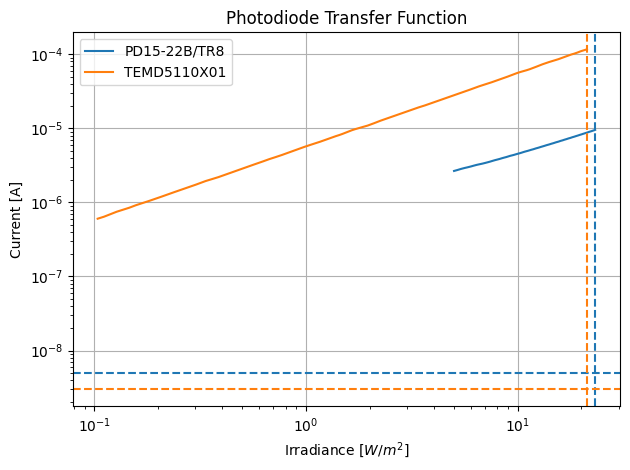

In [83]:
fig, ax = plt.subplots(tight_layout=True)
for diode, properties in PHOTODIODES.items():
    lc: xr.DataArray = properties["light_current"]
    lines = ax.loglog(lc.coords["irradiance"], lc, label=diode)

    ax.axhline(properties["dark_current"], color=lines[0].get_color(), linestyle="--")
    ax.axvline(
        np.max(lc.coords["irradiance"]), color=lines[0].get_color(), linestyle="--"
    )

ax.set_xlabel("Irradiance [$W/m^2$]")
ax.set_ylabel("Current [A]")
ax.grid(True)
ax.legend(loc="upper left")
ax.set_title("Photodiode Transfer Function")

Text(0.5, 1.0, 'Component comparison')

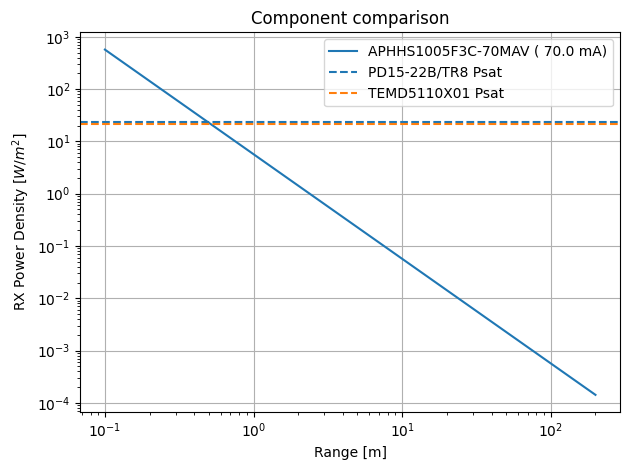

In [84]:
d = np.linspace(0.1, 200, 4000)  # downrange distance
area_objective = np.pi * (80e-3 / 2) ** 2
area_spot = np.pi * (3e-3 / 2) ** 2  # approximation
gain_optical = area_objective / area_spot

# Received power density
power_density = dict()
for led, properties in LEDS.items():
    incident_power = properties["emissivity"] * (1 / (d**2))  # W / m^2 at objective
    power_density[led] = incident_power * gain_optical

fig, ax = plt.subplots(tight_layout=True)
for led in LEDS:
    lines = ax.loglog(
        d,
        power_density[led],
        label=f"{led} ({LEDS[led]['emissivity_current']/1e-3:5.1f} mA)",
    )

ax.set_prop_cycle(None)  # reset color cycle to keep colors consistent across plots
for diode, properties in PHOTODIODES.items():
    ax.axhline(
        np.max(properties["light_current"].coords["irradiance"]),
        linestyle="--",
        label=f"{diode} Psat",
        color=ax._get_lines.get_next_color(),
    )

ax.set_xlabel("Range [m]")
ax.set_ylabel("RX Power Density [$W/m^2$]")
ax.grid(True)
ax.legend(loc="upper right")
ax.set_title("Component comparison")